# RL

In [56]:
## first, import the libraries we are going to use

import matplotlib.pyplot as plt
import sys
import numpy as np 
import math
import decimal
from collections import namedtuple
import pypfopt as pyp
import collections
from scipy import stats as st
import time
import random
import pandas as pd
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

In [4]:
minute_df_usd_price_est = pd.read_csv('minute_data_mid_usd_est.csv', index_col=0)
minute_df_usd_price_est = minute_df_usd_price_est[['USD.EUR.SPOT','USD.CAD.SPOT','USD.JPY.SPOT']]
minute_df_usd_price_est = minute_df_usd_price_est.ffill()
minute_df_usd_price_est.index = pd.to_datetime(minute_df_usd_price_est.index)

In [5]:
ret_df = minute_df_usd_price_est.pct_change()
ret_df_bps = ret_df*10000

In [6]:
hour_start = minute_df_usd_price_est.iloc[::60, :]

In [7]:
hour_start_train = hour_start[hour_start.index < pd.Timestamp(2022,5,1)]
hour_start_backtest = hour_start[(hour_start.index >= pd.Timestamp(2022,5,1)) & (hour_start.index < pd.Timestamp(2022,6,1))]
hour_start_test = hour_start[(hour_start.index >= pd.Timestamp(2022,6,1))]

In [8]:
hour_start_train

,USD.EUR.SPOT,USD.CAD.SPOT,USD.JPY.SPOT
time_est,,,
2022-01-02 18:00:00,1.137645,0.791258,0.008687
2022-01-02 19:00:00,1.137330,0.789999,0.008685
2022-01-02 20:00:00,1.136160,0.790267,0.008675
2022-01-02 21:00:00,1.135710,0.789777,0.008678
2022-01-02 22:00:00,1.134250,0.789092,0.008675
...,...,...,...
2022-04-29 12:00:00,1.053635,0.780930,0.007702
2022-04-29 13:00:00,1.055030,0.780323,0.007711
2022-04-29 14:00:00,1.057235,0.780582,0.007723


In [9]:
def runif(): 
    """uniform random number generator"""
    return np.random.uniform(0, 1, 1)[0]

In [10]:
def index_list(L): 
    """from a list, build a dictionary which list element to position"""
    return dict(zip(L, [x for x in range(0, len(L))]))

In [12]:
Action = namedtuple('Action', ['weight'])
State = namedtuple('State', ['ranking','hour'])

In [381]:
def get_ranking(securities_returns, lookback):
    ranking = {"Date":[],"USD.EUR":[],"USD.CAD":[],"USD.JPY":[],"hour":[]}
    var_asset = {"Date":[],"USD.EUR":[],"USD.CAD":[],"USD.JPY":[], "hour":[]}
    dates = []
#     for i in range(23*60,len(securities_returns),23*60):
    # at what interval you want to train
    interval = 60
    for i in range(0,len(securities_returns),interval):
        vector = securities_returns[i:i+lookback]
#         print(vector.index[0],vector.index[-1])
#         prior_vector = securities_returns[i-interval:i+lookback-interval]
        var = vector.var().values
        rank = var.argsort().argsort()
#         rank = tuple(-1*rank + 2)

        ranking["Date"].append(vector.index[-1]) # 0: forward looking (cheating), -1: lookback
        ranking["USD.EUR"].append(rank[0])
        ranking["USD.CAD"].append(rank[1])
        ranking["USD.JPY"].append(rank[2])
        ranking["hour"].append(vector.index[-1].hour) # 0: forward looking (cheating), -1: lookback
        
        var_asset["Date"].append(vector.index[-1]) # 0: forward looking (cheating), -1: lookback
        var_asset["USD.EUR"].append(var[0])
        var_asset["USD.CAD"].append(var[1])
        var_asset["USD.JPY"].append(var[2])
        var_asset["hour"].append(vector.index[-1].hour) # 0: forward looking (cheating), -1: lookback

        dates.append(vector.index[-1])
    ranking_df = pd.DataFrame(ranking, columns=['Date', 'USD.EUR', 'USD.CAD','USD.JPY','hour'])
    ranking_df.set_index('Date', inplace=True)
    
    var_asset_df = pd.DataFrame(var_asset, columns=['Date', 'USD.EUR', 'USD.CAD','USD.JPY','hour'])
    var_asset_df.set_index('Date', inplace=True)
    
    return ranking_df, var_asset_df

In [382]:
lookback = 60
rankings,var_asset = get_ranking(ret_df_bps,lookback)

In [383]:
rankings

,USD.EUR,USD.CAD,USD.JPY,hour
Date,,,,
2022-01-02 18:59:00,1,2,0,18
2022-01-02 19:59:00,2,1,0,19
2022-01-02 20:59:00,2,1,0,20
2022-01-02 21:59:00,1,2,0,21
2022-01-02 22:59:00,2,1,0,22
...,...,...,...,...
2022-06-30 12:59:00,2,0,1,12
2022-06-30 13:59:00,0,2,1,13
2022-06-30 14:59:00,1,2,0,14


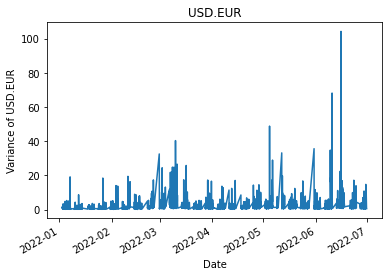

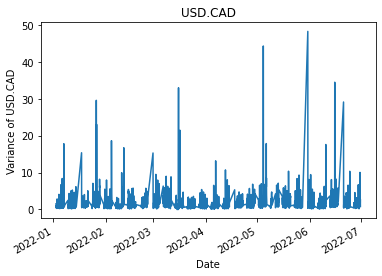

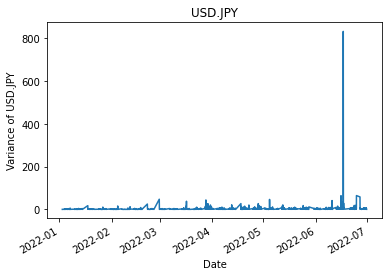

In [362]:
for col in var_asset.columns:
    if col == "hour":
        continue
    var_asset[col].plot()
    plt.title(col)
    plt.ylabel(f'Variance of {col}')
    plt.show()

In [1331]:
avg_rank = rankings[(rankings.index <= rankings.index[100]) & (rankings.hour == rankings.index[100].hour)].values.mean(axis=0)[:3]
avg_rank /= sum(avg_rank)
avg_rank

array([0.13333333, 0.2       , 0.66666667])

In [384]:
ranking_df_train = rankings[(rankings.index >= pd.Timestamp(2022,1,1)) & (rankings.index < pd.Timestamp(2022,5,1))]
ranking_df_test = rankings[(rankings.index >= pd.Timestamp(2022,5,1)) & (rankings.index < pd.Timestamp(2022,6,1))]

In [289]:
len(ranking_df_train)

1841

In [385]:
# weightOptions = [(1/3,1/3,1/3),(1/2,1/4,1/4),(1/4,1/2,1/4),(1/4,1/4,1/2)]
weightOptions = [(1/10,1/10,8/10),(1/10,8/10,1/10),(8/10,1/10,1/10),(1/3,1/3,1/3)]
# weightOptions = [(1,0,0),(0,1,0),(0,0,1)]
# weightOptions = [(1/3,1/3,1/3),(1,0,0),(0,1,0),(0,0,1)]

actionSpace = [Action(w) for w in weightOptions]

rankingSpace = [(0,1,2),(0,2,1),(1,0,2),(2,0,1),(1,2,0),(2,1,0)]
stateSpace = []
hours = np.arange(24)
hours = np.delete(hours,17)
for rank in rankingSpace:
    for h in hours:
        stateSpace.append(State(ranking=rank,hour=h))

# stateSpace = [State(ranking=rank,hour=h) for rank,h in combination(rankingSpace,hours)]

In [372]:
alpha = 0.01 ## learning rate

class TabularQLearner:
    def __init__(self, act_space, state_space, eps=0.1):
        self.actions = act_space
        self.states = state_space
        self.lookup = index_list(state_space)
        self.Q = np.zeros((len(self.states), len(self.actions)))
        self.epsilon = eps
        self.action_lookup = index_list(act_space)
        self.zero_trade = self.action_lookup[act_space[0]]

    def __greedy_action_index(self, state_index):
        """calculate the integer for indexing into self.Q or self.actions of the greedy action"""
        q = self.Q[state_index]
        if not np.any(q):
            return self.zero_trade
        else:
            return np.argmax(q)

    def greedy_action(self, state):
        """calculate the actual greedy action, not just its index"""
        return self.actions[self.__greedy_action_index(self.lookup[state])]

    def maxQ(self, state):
        return max(self.Q[self.lookup[state]])

    def train(self, rankings,epochs = 10):
        for _ in range(epochs):
            for r in range(0,len(rankings)-1):
    #             print(rankings.index[r])
                rank,hour = tuple(rankings.loc[rankings.index[r]].values)[:3],tuple(rankings.loc[rankings.index[r]].values)[-1]
                curr = State(ranking=rank,hour=hour)
    #             print(curr)
    #             state = tuple(np.argsort(np.argsort(train_df.var().values)))
    #             curr = State(state)
                i = self.lookup[curr]

                rand = runif()
                # with probability epsilon, select action randomly from amongst all available actions with equal probability
                if rand <= self.epsilon:
                    a = random.choice(self.actions)
                else:
                    a = self.greedy_action(curr)
                j = self.action_lookup[a]

                # for reward calculation
                train_df = ret_df_bps[(ret_df_bps.index <= rankings.index[r+1]) & (ret_df_bps.index > rankings.index[r])]
#                 print(train_df)
    #             average_rank = rankings[(rankings.index <= rankings.index[r]) & (rankings.hour == rankings.index[r].hour)].values.mean(axis=0)[:3]
    #             print(train_df.index[0],train_df.index[-1])
    #             average_rank /= sum(average_rank)
    #             opt_weights = np.array(a.weight)*average_rank / sum(np.array(a.weight)*average_rank)

                train_performance = np.array(a.weight)*train_df
                train_port = train_performance.sum(axis=1)
    #             print(train_performance)
                reward = -train_port.var()
    #             print(reward)

                self.Q[i,j] = self.Q[i,j] + alpha * (reward - self.Q[i,j])
        

In [386]:
learner = TabularQLearner(actionSpace, stateSpace, eps=0.1)
learner.train(ranking_df_train,epochs = 1)

In [345]:
grouped_ranking = {}
var_asset_ranking = {}
count = {}
for state in stateSpace:
    (a,b,c),hour = state.ranking,state.hour
    grouped_ranking[(a,b,c)] = rankings.loc[(rankings['USD.EUR'] == a) & (rankings['USD.CAD'] == b) & (rankings['USD.JPY'] == c)]
    var_asset_ranking[(a,b,c)] = var_asset.loc[var_asset.index.isin(grouped_ranking[(a,b,c)].index)]              
    count[(a,b,c)] = len(grouped_ranking[(a,b,c)])

In [346]:
count

{(0, 1, 2): 357,
 (0, 2, 1): 266,
 (1, 0, 2): 616,
 (2, 0, 1): 436,
 (1, 2, 0): 485,
 (2, 1, 0): 623}

In [347]:
currency = ['USD.EUR', 'USD.CAD','USD.JPY']

In [408]:
qfunction_rank = pd.DataFrame(columns=['Ranking', 'optimal_weight_eur', 'optimal_weight_cad', 'optimal_weight_jpy'])
qfunction_hour = pd.DataFrame(columns=['Hour', 'optimal_weight_eur', 'optimal_weight_cad', 'optimal_weight_jpy'])
qfunction_rank_hour = pd.DataFrame(columns=['Ranking','Hour', 'optimal_weights',"currency"])

ranking_weights = collections.defaultdict(list)
hour_weights = collections.defaultdict(list)

for s in stateSpace:
    optimal_weight = learner.greedy_action(s).weight
#     if count[s.ranking] < 10:
#         continue
    ranking_weights[s.ranking].append(np.array(optimal_weight))
    hour_weights[s.hour].append(np.array(optimal_weight))
    max_weight_curr = np.array(optimal_weight).argmax()
    qfunction_rank_hour = qfunction_rank_hour.append({'Ranking': s.ranking, 'Hour':s.hour,'optimal_weights': optimal_weight[max_weight_curr], "currency": currency[max_weight_curr]}, ignore_index = True)

for rank in ranking_weights.keys():
    optimal_weight_rank = np.array(ranking_weights[rank]).mean(axis=0)
    qfunction_rank = qfunction_rank.append({'Ranking': rank, 'optimal_weight_eur': optimal_weight_rank[0], 'optimal_weight_cad': optimal_weight_rank[1], 'optimal_weight_jpy': optimal_weight_rank[2]}, ignore_index = True)
for hour in hour_weights.keys():
    optimal_weight_hour = np.array(hour_weights[hour]).mean(axis=0)
    qfunction_hour = qfunction_hour.append({'Hour': hour, 'optimal_weight_eur': optimal_weight_hour[0], 'optimal_weight_cad': optimal_weight_hour[1], 'optimal_weight_jpy': optimal_weight_hour[2]}, ignore_index = True)



In [409]:
qfunction_rank_hour

,Ranking,Hour,optimal_weights,currency
0,"(0, 1, 2)",0,0.800000,USD.JPY
1,"(0, 1, 2)",1,0.800000,USD.EUR
2,"(0, 1, 2)",2,0.800000,USD.EUR
3,"(0, 1, 2)",3,0.333333,USD.EUR
4,"(0, 1, 2)",4,0.800000,USD.EUR
...,...,...,...,...
133,"(2, 1, 0)",19,0.800000,USD.JPY
134,"(2, 1, 0)",20,0.800000,USD.CAD
135,"(2, 1, 0)",21,0.800000,USD.CAD
136,"(2, 1, 0)",22,0.800000,USD.CAD


<AxesSubplot:xlabel='Hour', ylabel='Ranking'>

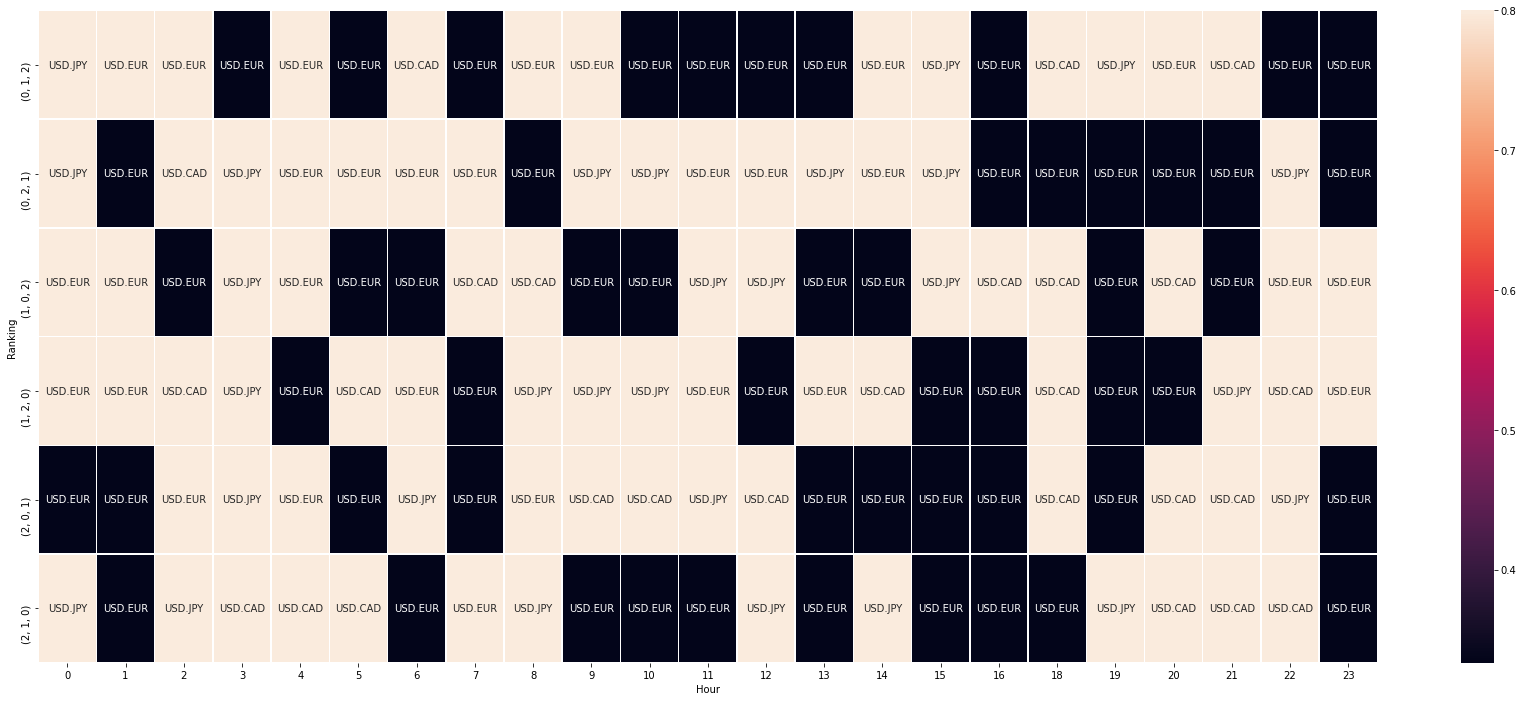

In [410]:
pivot = qfunction_rank_hour.pivot(index='Hour', columns='Ranking', values=['optimal_weights','currency']).T
f, ax = plt.subplots(figsize=(30, 12))
pivot_table = pivot.loc['optimal_weights'].astype(float)
M = pivot.loc['currency']
N = pivot.loc['optimal_weights']
A = np.array([[f'{M[i][j]}' for j in range(6)] for i in hours])
sns.heatmap(pivot_table, annot=A.T, linewidths=.5, ax=ax, fmt='')

In [352]:
qfunction_rank

,Ranking,optimal_weight_eur,optimal_weight_cad,optimal_weight_jpy
0,"(0, 1, 2)",0.391304,0.521739,0.086957
1,"(0, 2, 1)",0.434783,0.173913,0.391304
2,"(1, 0, 2)",0.304348,0.608696,0.086957
3,"(2, 0, 1)",0.173913,0.434783,0.391304
4,"(1, 2, 0)",0.391304,0.217391,0.391304
5,"(2, 1, 0)",0.043478,0.347826,0.608696


In [353]:
qfunction_hour

,Hour,optimal_weight_eur,optimal_weight_cad,optimal_weight_jpy
0,0.0,0.166667,0.500000,0.333333
1,1.0,0.333333,0.500000,0.166667
2,2.0,0.166667,0.500000,0.333333
3,3.0,0.333333,0.333333,0.333333
4,4.0,0.000000,0.500000,0.500000
5,5.0,0.333333,0.166667,0.500000
6,6.0,0.166667,0.666667,0.166667
7,7.0,0.166667,0.333333,0.500000
8,8.0,0.333333,0.166667,0.500000
9,9.0,0.000000,0.500000,0.500000


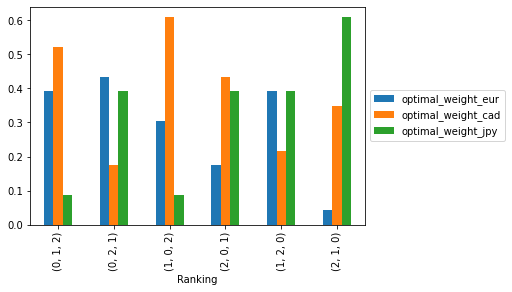

In [354]:
ax = qfunction_rank.set_index('Ranking').plot(kind='bar',stacked=False)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

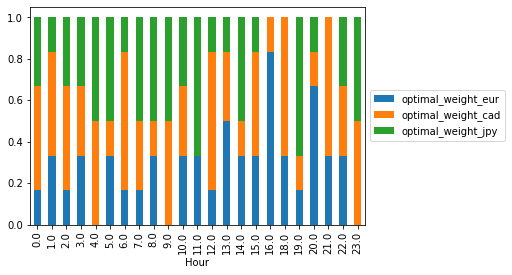

In [355]:
ax = qfunction_hour.set_index('Hour').plot(kind='bar',stacked=True)
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [356]:
learner.Q

array([[-0.23435424, -0.23155978, -0.23851384],
       [-0.25021065, -0.24801029, -0.25021087],
       [-0.06167309, -0.06159981, -0.06189102],
       [-0.21159819, -0.23592109, -0.22926527],
       [-0.07913484, -0.07551183, -0.08867455],
       [-0.10057448, -0.10525996, -0.11832127],
       [-0.01957539, -0.02710252, -0.02531218],
       [-0.11281159, -0.11155254, -0.13429038],
       [-0.1161247 , -0.11019517, -0.12209762],
       [-0.25731539, -0.22615937, -0.23645259],
       [-0.44604212, -0.51595289, -0.42237766],
       [-0.28872551, -0.29523724, -0.32667973],
       [-0.139796  , -0.13786345, -0.14570189],
       [-0.37548595, -0.40171436, -0.41211652],
       [-0.05001272, -0.05020136, -0.0452747 ],
       [-0.26783981, -0.26755174, -0.295421  ],
       [-0.1059915 , -0.10627249, -0.10747095],
       [-0.28074255, -0.28124243, -0.28505922],
       [-0.36192533, -0.36441581, -0.37482359],
       [-0.54780602, -0.55534484, -0.6604589 ],
       [-0.47994002, -0.47387446, -0.505

In [417]:
test_return = pd.DataFrame()
interval = 1
for i in range(0,len(ranking_df_test)-1,interval):
#     print("ranking",ranking_df_test.loc[ranking_df_test.index[i]])
    rank,hour = tuple(ranking_df_test.loc[ranking_df_test.index[i]].values)[:3],tuple(ranking_df_test.loc[ranking_df_test.index[i]].values)[-1]
#     print(rank,hour)
    
    curr = State(ranking =rank,hour = hour)
    optimal_weight = learner.greedy_action(curr).weight
    w = np.array([0,0,0])
    w[np.array(rank).argmin()] = 1
#     if list(w) != list(optimal_weight):
#         print("rank: ",rank)
#         print("optimal_weight: ",optimal_weight)
#         print("w: ",w)
    test_df = ret_df[(ret_df_bps.index <= ranking_df_test.index[i+1]) & (ret_df_bps.index > ranking_df_test.index[i])]
#     average_rank = rankings[(rankings.index <= ranking_df_test.index[i]) & (rankings.hour == ranking_df_test.index[i].hour)].values.mean(axis=0)[:3]
#     print("test",test_df.index[0],test_df.index[-1])

#     average_rank /= sum(average_rank)
#     opt_weights = np.array(optimal_weight)*average_rank / sum(np.array(optimal_weight)*average_rank)
    
    test_performance = list(optimal_weight)*test_df
    test_port = test_performance.sum(axis=1)
    test_return = test_return.append(pd.DataFrame(test_port))

test_return.std()*np.sqrt(23*60*252)

0    0.07924
dtype: float64

In [430]:
test_return = pd.DataFrame()
test_return_minvar = pd.DataFrame()
interval = 1
for i in range(0,len(ranking_df_test)-1,interval):
    rank,hour = tuple(ranking_df_test.loc[ranking_df_test.index[i]].values)[:3],tuple(ranking_df_test.loc[ranking_df_test.index[i]].values)[-1]
    
#     curr = State(ranking =rank,hour = hour)
    minvar_weights = np.array([0,0,0])
    minvar_weights[np.array(rank).argmin()] = 1
    
    
    optimal_weight = qfunction_rank.loc[qfunction_rank["Ranking"]==rank].values[0][1:]
    test_df = ret_df[(ret_df_bps.index <= ranking_df_test.index[i+1]) & (ret_df_bps.index > ranking_df_test.index[i])]
    
    test_performance = list(optimal_weight)*test_df
    test_port = test_performance.sum(axis=1)
    test_return = test_return.append(pd.DataFrame(test_port))
    
    test_performance_minvar = list(minvar_weights)*test_df
    test_port_min_var = test_performance_minvar.sum(axis=1)
    test_return_minvar = test_return.append(pd.DataFrame(test_port_min_var))

print("Test agent optimal weights portfolio std: ",test_return.std()*np.sqrt(23*60*252))
print("Test minvar optimal weights portfolio std: ",test_return_minvar.std()*np.sqrt(23*60*252))

Test agent optimal weights portfolio std:  0    0.068288
dtype: float64
Test minvar optimal weights portfolio std:  0    0.068238
dtype: float64


In [415]:
test_return = pd.DataFrame()
interval = 1
for i in range(0,len(ranking_df_test)-1,interval):
    rank,hour = tuple(ranking_df_test.loc[ranking_df_test.index[i]].values)[:3],tuple(ranking_df_test.loc[ranking_df_test.index[i]].values)[-1]

#     curr = State(ranking =rank,hour = hour)

    optimal_weight = qfunction_hour.loc[qfunction_hour["Hour"]==hour].values[0][1:]

    test_df = ret_df[(ret_df_bps.index <= ranking_df_test.index[i+1]) & (ret_df_bps.index > ranking_df_test.index[i])]
    
    test_performance = list(optimal_weight)*test_df
    test_port = test_performance.sum(axis=1)
    test_return = test_return.append(pd.DataFrame(test_port))

test_return.std()*np.sqrt(23*60*252)

0    0.071092
dtype: float64

In [1515]:
f"Test return = {round(((1+test_return).cumprod()-1).iloc[-1].values[0]*100,3)}%"

'Test return = 1.608%'

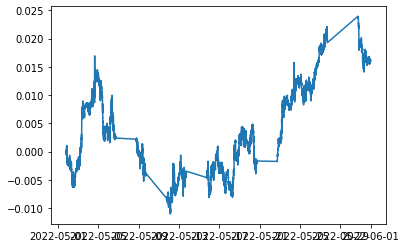

In [1516]:
plt.plot((1+test_return).cumprod() -1)